In [76]:
import json
from glob import glob

import seaborn as sb
import pandas as pd

In [2]:
def f():
    with open('../parliaments/parliament47.json', 'r', encoding='utf-8') as f:
        parliament = json.load(f)
    mapping = {x['_id']: x['name'] for x in parliament['parlGroups']}
    return mapping
mapping = f()

In [54]:
def g(x):
    ans = []
    for session_vote in x['sessionVotes']:
        if session_vote['voteType'] == 'registration':
            continue
        for summary in session_vote['summary']:
            for vote in summary['votes']:
                ans.append({
                    'vote_id': session_vote['_id'],
                    'vote_name': session_vote['name'],
                    'parlGroup': summary['parlGroup'],
                    'decision': vote['decision'],
                    'count': vote['count'],
                })
    return ans


def f():
    xs = []
    for fn in glob('../sessions/*.json'):
        with open(fn, 'r', encoding='utf-8') as f:
            x = json.load(f)
            if not x:
                continue
            xs.extend(g(x))
    return pd.DataFrame(xs)
xs = f()
xs['parlGroup_name'] = xs['parlGroup'].map(mapping)

In [55]:
xs['decision_unified'] = xs['decision'].map({
    'no-vote': 0,      # не гласувал
    'yes': 1,          # да
    'abstain': 0,      # въздържал се
    'no': -1,          # не
    'not-present': 0,  # registration: отсъстващ
    'present': 0,      # registration: регистриран
    'r-present': 0,    # registration: ръчно регистриран
}).mul(xs['count'])

In [107]:
grouped = xs.groupby(['vote_id', 'parlGroup_name'])
stacked = grouped['decision_unified'].sum().div(grouped['count'].sum())
votes = stacked.unstack()
corr = votes.corr()

In [123]:
corr.index.rename('', inplace=True)
corr.columns.rename('Парламентарна група', inplace=True)

In [124]:
corr

Парламентарна група,БСП за България,Възраждане,ГЕРБ-СДС,Движение за права и свободи,Демократична България,Има такъв народ,Независими,Продължаваме промяната
,,,,,,,,
БСП за България,1.000000,-0.142250,-0.454466,-0.340105,0.831658,0.694354,0.761880,0.890474
Възраждане,-0.142250,1.000000,0.303498,0.323492,-0.177065,-0.032194,-0.154133,-0.182380
ГЕРБ-СДС,-0.454466,0.303498,1.000000,0.700253,-0.419986,-0.222931,-0.351635,-0.448299
Движение за права и свободи,-0.340105,0.323492,0.700253,1.000000,-0.314888,-0.114960,-0.371374,-0.337062
Демократична България,0.831658,-0.177065,-0.419986,-0.314888,1.000000,0.696627,0.767493,0.898064
Има такъв народ,0.694354,-0.032194,-0.222931,-0.114960,0.696627,1.000000,0.287998,0.729022
Независими,0.761880,-0.154133,-0.351635,-0.371374,0.767493,0.287998,1.000000,0.852255
Продължаваме промяната,0.890474,-0.182380,-0.448299,-0.337062,0.898064,0.729022,0.852255,1.000000


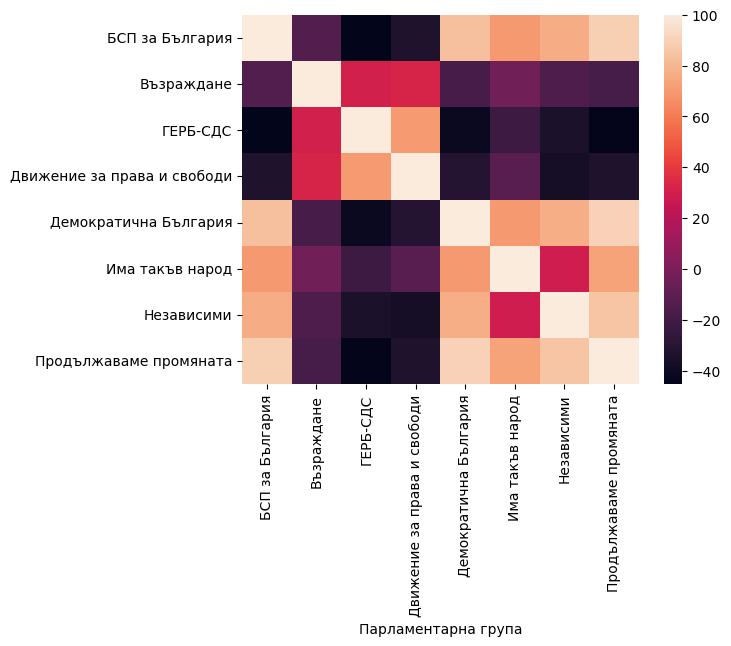

In [127]:
sb.heatmap(corr * 100);